In [ ]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [ ]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'/3DDP/HW2/
!ls

/content/drive/MyDrive/Colab Notebooks/3DDP/HW2
left.png  right.png  Stereo_Matching.ipynb


In [ ]:
left_img = cv2.imread('left.png')
right_img = cv2.imread('right.png')

intrinsic_matrix = np.array([[1.09029096e+03, 0.00000000e+00, 7.07542608e+02], [0.00000000e+00, 1.08922050e+03, 5.45461473e+02],
                             [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],np.float64)
dist = np.array([[ 1.65437913e-01, -5.79061012e-01,  2.96852001e-04, -5.97762518e-04,   8.06805488e-01]],np.float64)

R = np.array([[1,0,0], [0,1,0],[0,0,1]],np.float64)
T = np.array([0.01,0,0],np.float64) 

image_size = (left_img.shape[1], left_img.shape[0])
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(intrinsic_matrix, dist, intrinsic_matrix, dist, image_size, R, T)

map1, map2 = cv2.initUndistortRectifyMap(intrinsic_matrix, dist, R1, P1,image_size, cv2.CV_32FC1)
dst1 = cv2.remap(left_img, map1,map2, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)

map3,map4 = cv2.initUndistortRectifyMap(intrinsic_matrix, dist, R2,P2,image_size, cv2.CV_32FC1)
dst2 = cv2.remap(right_img, map3,map4, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)

cv2_imshow(dst1)
cv2_imshow(dst2)

# R은 각 카메라를 위한 3*3 rectification rotation matrix이다.
# P는 각 카메라의 새로운 rectified 좌표계에서의  3*4 projection matrix이다.
# Q는 disparity to depth mapping matrix이다. 
# roi 


Output hidden; open in https://colab.research.google.com to view.

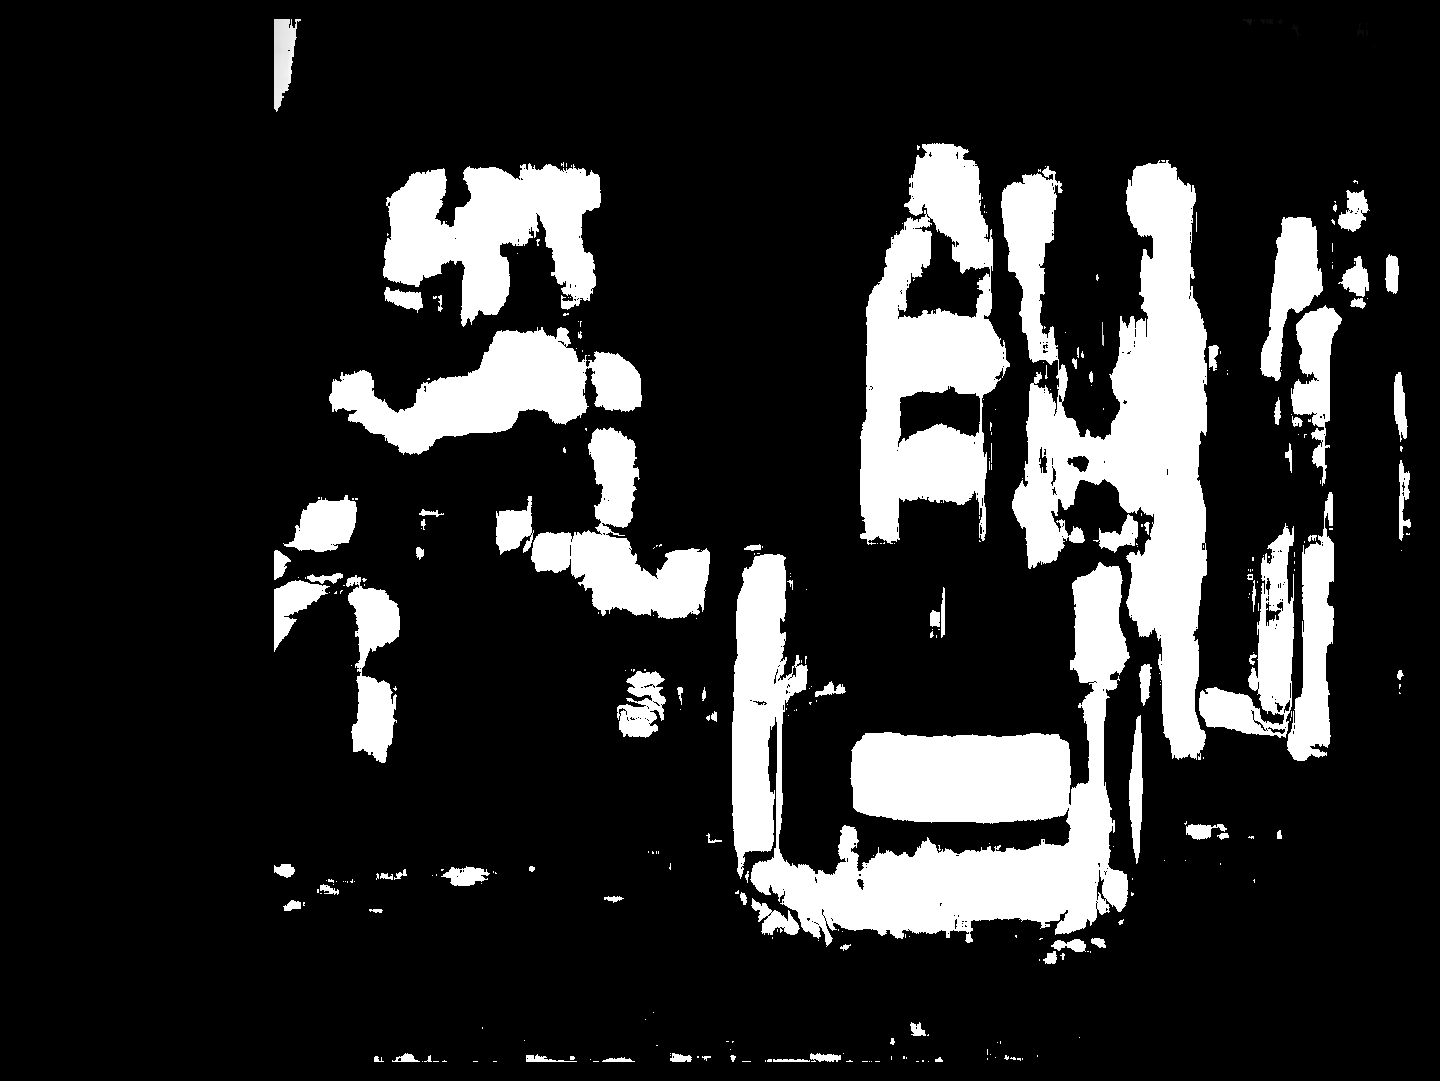

In [ ]:
gray1 = cv2.cvtColor(dst1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(dst2,cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(numDisparities=256, blockSize = 39)
disparity = stereo.compute(gray1,gray2)
#disparity = cv2.normalize(disparity,disparity,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,
 #           dtype=cv2.CV_8U)

cv2_imshow(disparity)

In [ ]:
import math

h, w, ch = left_img.shape
colors = []
points = []

f_x = intrinsic_matrix[0,0]
f_y = intrinsic_matrix[1,1]
c_x = intrinsic_matrix[0,2]
c_y = intrinsic_matrix[1,2]
# target distance unit: meter
Z = 1.0 

sampling_rate = 10

for v in range(0,h,sampling_rate):
  for u in range(0,w,sampling_rate):
    if disparity[int(v),int(u)]>0 :
      color = left_img[int(v),int(u),:]
      if color[0]==0 and color[1]==0 and color[2]==0:
        continue
      else:
        Z = 0.01 * 1.08922050e+03 / disparity[int(v),int(u)]
        if Z<0.5:
          X = (u - c_x) * Z / f_x
          Y = (v - c_y) * Z / f_y
          points.append([X,Y,Z])
          colors.append([color[2]/255.0,color[1]/255.0,color[0]/255.0])

points=np.array(points)
colors=np.array(colors)

# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(points)
pcd_o3d.colors=o3d.utility.Vector3dVector(colors)

def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
o3d.visualization.draw_geometries = draw_geometries # replace function

o3d.visualization.draw_geometries([pcd_o3d])